# Lista 3: Dobre praktyki

In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Definiujemy transformacje
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root="./zad3/data",
    train=True,
    download=True,
    transform=transform
)

testset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 26.4M/26.4M [00:04<00:00, 5.32MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.54MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 7.95MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Wyświetlmy przykładowe obrazy:

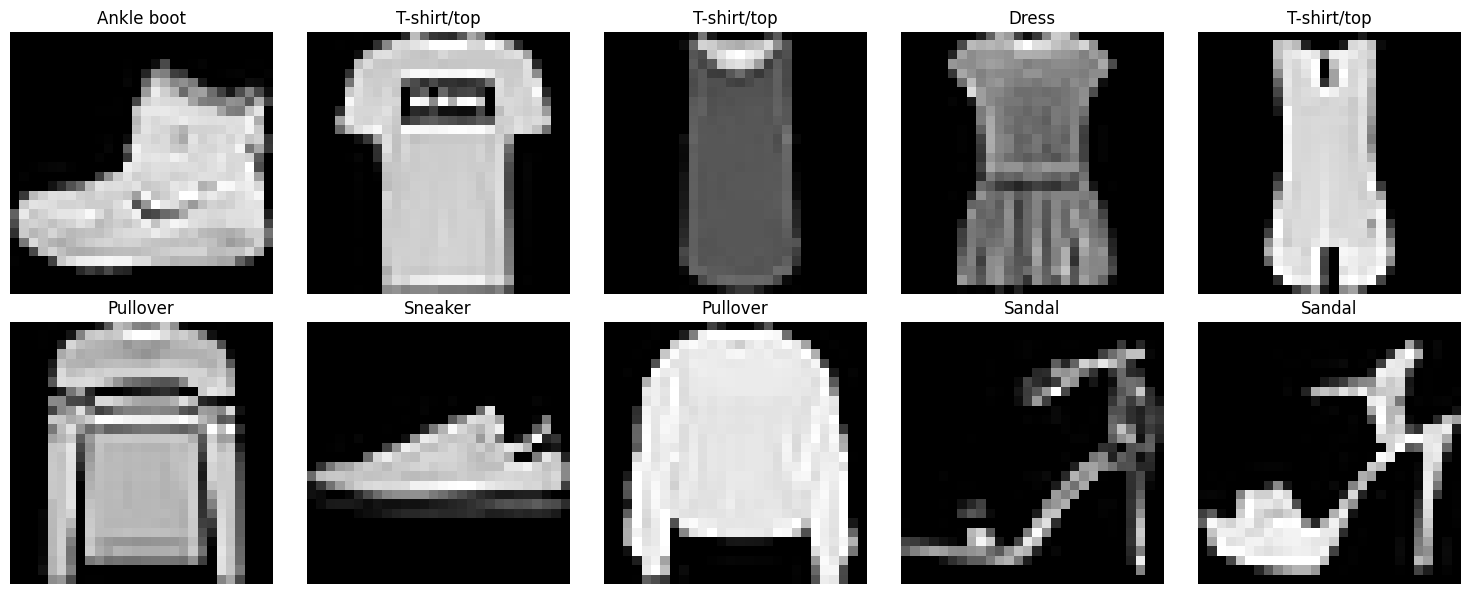

In [ ]:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img, label = trainset[i]
    img = img.numpy().squeeze()
    
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'{class_names[label]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Wypiszmy jeszcze do tego może jakieś informacje o tych zdjęciach

In [7]:
print(f"Liczba obrazów treningowych: {len(trainset)}")
print(f"Liczba obrazów testowych: {len(testset)}")

img, label = trainset[0]
print(f"\nKształt tensora obrazu: {img.shape}")
print(f"Typ danych: {img.dtype}")
print(f"Zakres wartości: min={img.min():.3f}, max={img.max():.3f}")

print(f"\nLiczba klas: {len(class_names)}")
print(f"Nazwy klas: {class_names}")

from collections import Counter
labels = [label for _, label in trainset]
label_counts = Counter(labels)
print(f"\nRozkład klas w zbiorze treningowym:")
for i, count in sorted(label_counts.items()):
    print(f"  {class_names[i]}: {count} obrazów")


Liczba obrazów treningowych: 60000
Liczba obrazów testowych: 10000

Kształt tensora obrazu: torch.Size([1, 28, 28])
Typ danych: torch.float32
Zakres wartości: min=0.000, max=1.000

Liczba klas: 10
Nazwy klas: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Rozkład klas w zbiorze treningowym:
  T-shirt/top: 6000 obrazów
  Trouser: 6000 obrazów
  Pullover: 6000 obrazów
  Dress: 6000 obrazów
  Coat: 6000 obrazów
  Sandal: 6000 obrazów
  Shirt: 6000 obrazów
  Sneaker: 6000 obrazów
  Bag: 6000 obrazów
  Ankle boot: 6000 obrazów


klasy są równiótko podzielone, żadna nie odstaje ilościowo od reszty, zdjęcie to jest w skali szarości i ma wymiary 28 na 28 no i jest 10 etykiet (różnych rodzajów odzieży)